# Preprocessing

In [152]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
%autoreload 2

In [154]:
import torch

In [384]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.vfm.model.reg.gradient_boost import GradientBoost
from src.vfm.model.nn.swt_tft import SWTTFTModel
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel, PhysicsModel
from src.utils import *
import matplotlib.pyplot as plt
import os

In [340]:
connection = Connection()
# Get client
client = connection.get_client()

In [367]:
df_all_wells = connection.get_data(client, wells=[get_all_wells()[0]])

In [368]:
df_all_wells.columns


Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [369]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [370]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']


100

In [371]:
summarize_null(df_all_wells_preprocessed)

dhp          0
dht          0
whp          0
wht          0
dcp          0
choke        0
well_id      0
qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
time_idx     0
well_code    0
dtype: int64

In [372]:
df_with_targets = df_all_wells_preprocessed.dropna(subset=dependent_vars)
df_with_targets.shape

(100, 12)

In [373]:
summarize_null(df_with_targets)

dhp          0
dht          0
whp          0
wht          0
dcp          0
choke        0
well_id      0
qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
time_idx     0
well_code    0
dtype: int64

In [418]:
df_train, df_test = get_random_train_test_split_per_well_with_order_preserved(df_with_targets)
len(df_train), len(df_test)

(78, 22)

In [419]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df_train)

c:\Users\perer\Documents\Code\pcperera\vfm\src\vfm\model\physics\physics_informed.py:13: RuntimeWarning: invalid value encountered in log1p
  # =====================================================


ValueError: Input y contains NaN.

In [ ]:
model.physics_score(df_test)

{'W06': {'qo': {'r2': 0.5644459767824592,
   'mae': 19.567280072405953,
   'rmse': 22.857624779510566,
   'mre': 20.293855868570525},
  'qw': {'r2': 0.03517351445874206,
   'mae': 38.78782621544995,
   'rmse': 68.51775779850044,
   'mre': 137038473.87843758},
  'qg': {'r2': 0.3188757921000517,
   'mae': 2692.125032459694,
   'rmse': 3289.2094317574756,
   'mre': 17.03423169942241},
  'wgr': {'r2': 0.053206349435414246,
   'mae': 0.002716408660123384,
   'rmse': 0.004677150393073647,
   'mre': 32425.346665014604}}}

In [ ]:
model.hybrid_score(df_test)

{'qo': {'r2': 0.03147576452066103,
  'mae': 26.40772267956016,
  'rmse': 30.789397500733035,
  'mre': 26.67169878010009},
 'qw': {'r2': -0.09288536980439854,
  'mae': 38.89998464650998,
  'rmse': 75.04529656644704,
  'mre': 9103710.234143678},
 'qg': {'r2': 0.55539042464143,
  'mae': 1858.3276599130481,
  'rmse': 2412.89542758926,
  'mre': 16.652775177257027},
 'wgr': {'r2': -0.028707298845526585,
  'mae': 0.0027042935189251186,
  'rmse': 0.005028137407964154,
  'mre': 1507.0166295636604}}

In [ ]:
# model.plot_predictions(df=df_test, time_col="time_idx", is_physics_only=True)

In [ ]:
df_test.columns

Index(['dhp', 'dht', 'whp', 'wht', 'dcp', 'choke', 'well_id', 'qo_mpfm',
       'qg_mpfm', 'qw_mpfm', 'time_idx', 'well_code'],
      dtype='object')

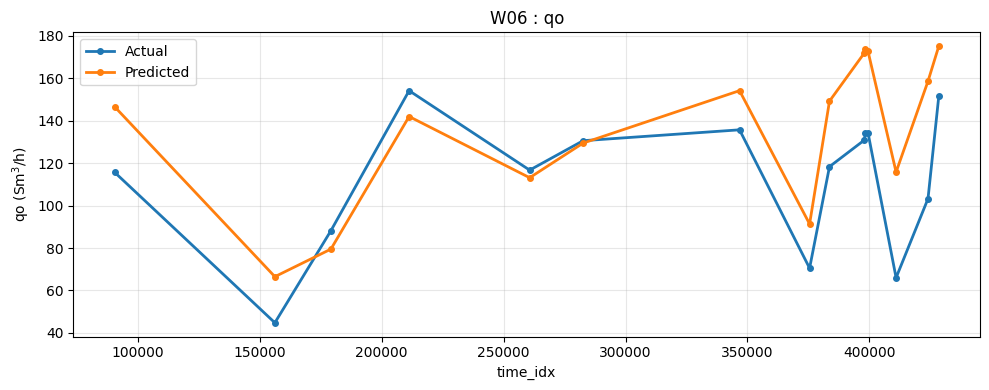

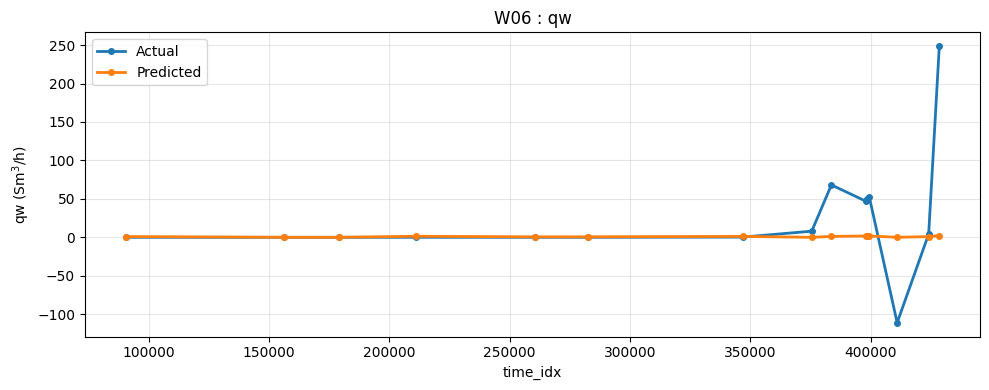

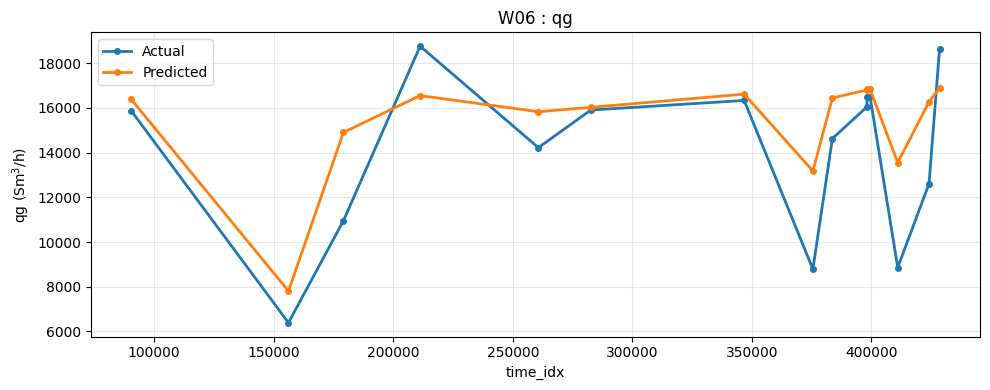

In [ ]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)

In [ ]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [ ]:
# lowo_with_partial_calibration(df=df_with_targets)